In [1]:
from random import randint
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.applications.densenet import DenseNet121
from keras.models import Model, load_model
from keras.callbacks import History, Callback, ModelCheckpoint, LearningRateScheduler
from project_utils import train_generator, validation_generator, prediction_generator


Using TensorFlow backend.


In [ ]:
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [2]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [17]:
# x-ray class to int encoding and vice versa
class_to_int = {'XR_SHOULDER':0, 'XR_HUMERUS':1, 'XR_ELBOW':2, 'XR_FOREARM':3, 'XR_WRIST':4, 'XR_HAND':5, 'XR_FINGER':6}
int_to_class = ['XR_SHOULDER', 'XR_HUMERUS', 'XR_ELBOW', 'XR_FOREARM', 'XR_WRIST', 'XR_HAND', 'XR_FINGER']
NUM_CLASS = 7

# image size
IMG_W = 320
IMG_H = 320
IMG_C = 3

# train image paths and their int_class
train_img_paths = np.array(open('MURA-v1.1/train_image_paths.csv', 'r').readlines())
train_img_class = np.array(open('MURA-v1.1/train_image_class.csv', 'r').readlines()).astype(int)

# validation image paths and their int_class
valid_img_paths = np.array(open('MURA-v1.1/valid_image_paths.csv', 'r').readlines())
valid_img_class = np.array(open('MURA-v1.1/valid_image_class.csv', 'r').readlines()).astype(int)

In [4]:
K.clear_session() # clear default graph

In [5]:
s = reset_tf_session() # reseting the session to avoid memory problem

In [6]:
def densenet_model():
    # creating the base pre-trained model
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_H, IMG_W, IMG_C))

    # add a global spatial average pooling layer
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dense(64, activation='relu')(X)
    # add a logistic layer
    Y = Dense(NUM_CLASS, activation='softmax')(X)

    # defining the model
    model = Model(inputs=base_model.input, outputs=Y)
    return model

In [7]:
model = densenet_model()

In [8]:
BATCH_SIZE = 8

In [9]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))


In [10]:
# for setting which layers to be trained
for layer in model.layers:
    layer.trainable = True


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [18]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'densenet2_{epoch:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
s = reset_tf_session()
last_finished_epoch = 36
model = load_model(model_filename.format(epoch=last_finished_epoch))
    

In [27]:
def lr_scheduler(epoch):
    lrate = 0.001
    return lrate*(0.1**(int(epoch/3)))

In [15]:
INIT_LR = 0.001
adam = optimizers.Adam(INIT_LR)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [30]:
# fit model
batch_history = LossHistory()
history = History()
model.fit_generator(train_generator(train_img_paths, train_img_class, BATCH_SIZE, NUM_CLASS), 
                    steps_per_epoch = len(train_img_class)/BATCH_SIZE,
                    epochs = 5,
                    validation_data = validation_generator(valid_img_paths, valid_img_class, BATCH_SIZE, NUM_CLASS),
                    validation_steps = 100,
                    callbacks = [history, ModelCheckpoint(model_filename), batch_history, LearningRateScheduler(lr_scheduler)],
                    initial_epoch = last_finished_epoch or 0)

Epoch 59/150
300/300 [==============================] - 310s 1s/step - loss: 0.1436 - acc: 0.9558 - val_loss: 0.1308 - val_acc: 0.9613
Epoch 60/150
300/300 [==============================] - 311s 1s/step - loss: 0.1256 - acc: 0.9633 - val_loss: 0.1681 - val_acc: 0.9525
Epoch 61/150
300/300 [==============================] - 311s 1s/step - loss: 0.1336 - acc: 0.9587 - val_loss: 0.1627 - val_acc: 0.9537
Epoch 62/150
300/300 [==============================] - 311s 1s/step - loss: 0.1427 - acc: 0.9567 - val_loss: 0.1714 - val_acc: 0.9511
Epoch 63/150
300/300 [==============================] - 311s 1s/step - loss: 0.1268 - acc: 0.9613 - val_loss: 0.1676 - val_acc: 0.9537
Epoch 64/150
300/300 [==============================] - 359s 1s/step - loss: 0.1249 - acc: 0.9683 - val_loss: 0.1228 - val_acc: 0.9637
Epoch 65/150
300/300 [==============================] - 362s 1s/step - loss: 0.1220 - acc: 0.9688 - val_loss: 0.1606 - val_acc: 0.9637
Epoch 66/150
300/300 [==============================] -

KeyboardInterrupt: 

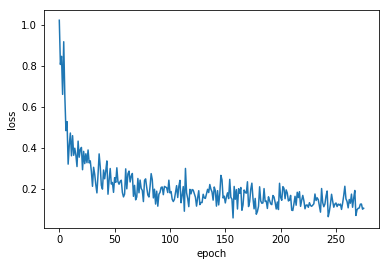

In [31]:
avg_loss = []
temp = batch_history.losses[:13800]
i = 0
while i<13800:
    t = sum(temp[i:i+50])/50
    avg_loss.append(t)
    i+=50


plt.plot(avg_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

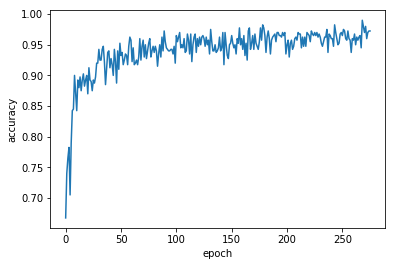

In [32]:
avg_acc = []
temp_acc = batch_history.acc[:13800]
i = 0
while i<13800:
    t = sum(temp_acc[i:i+50])/50
    avg_acc.append(t)
    i+=50


plt.plot(avg_acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [24]:
batch_loss = open('batch_losses_densenet5.txt', 'w')
for loss in batch_history.losses:
    batch_loss.write(str(loss)+'\n')
    
batch_acc = open('batch_acc_densenet5.txt', 'w')
for acc in batch_history.acc:
    batch_acc.write(str(acc)+'\n')
    
batch_loss.close()
batch_acc.close()

In [25]:
val_loss = open('val_losses_densenet5.txt', 'w')
for loss in batch_history.val_losses:
    val_loss.write(str(loss)+'\n')

val_acc = open('val_acc_densenet5.txt', 'w')
for acc in batch_history.val_acc:
    val_acc.write(str(acc)+'\n')

val_loss.close()
val_acc.close()

In [26]:
import json
with open('epoch_metrics_densenet5.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
from collections import Counter
cnt = Counter()
for c in valid_img_class:
    cnt[c]+=1
print(cnt)

In [ ]:
predict_img_paths = []
predict_img_class = []
cnt = Counter()
for i in range(len(valid_img_paths)):
    if cnt[valid_img_class[i]]<288:
        predict_img_paths.append(valid_img_paths[i])
        predict_img_class.append(valid_img_class[i])
    cnt[valid_img_class[i]]+=1

predict_img_paths = np.array(predict_img_paths)
predict_img_class = np.array(predict_img_class)

In [58]:
pred_y = model.predict_generator(prediction_generator(predict_img_paths, BATCH_SIZE), steps=len(predict_img_paths)/BATCH_SIZE)

In [59]:
pred_y_class = np.argmax(pred_y, axis=1)
print(pred_y_class.shape)

(2016,)


In [54]:
print(len(predict_img_paths))

2016


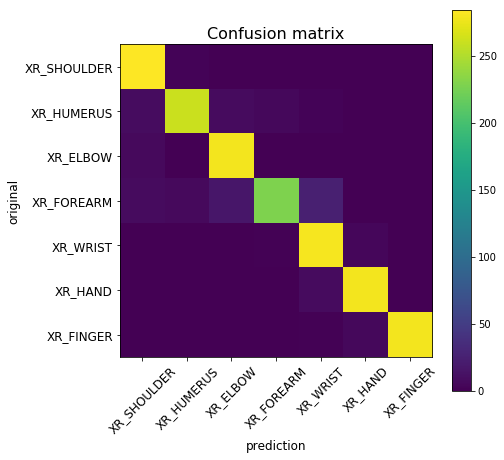

Test accuracy: 0.937996031746


In [60]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 7))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(predict_img_class, pred_y_class))
plt.xticks(np.arange(NUM_CLASS), int_to_class, rotation=45, fontsize=12)
plt.yticks(np.arange(NUM_CLASS), int_to_class, fontsize=12)
plt.xlabel('prediction', fontsize = 12)
plt.ylabel('original', fontsize = 12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(predict_img_class, pred_y_class))